In [275]:
import shap 
import pandas as pd
import numpy as np
import sklearn as sk
import math
import matplotlib.pyplot as plt
from sklearn import linear_model
from itertools import permutations


In [252]:
np.random.seed(123)
shape=1000,3
sample_df = pd.DataFrame(
    np.random.lognormal(mean=1,size=shape),
    columns=["X{}".format(x) for x in range(1,4)],
    index=["I{}".format(x) for x in range(1,shape[0]+1)]
)
sample_df["Y"] = 2*sample_df["X1"] - sample_df["X2"] 

In [253]:
%%time

model = linear_model.LinearRegression()

X= sample_df.iloc[:,0:3]
Y= sample_df.iloc[:,3]

model=model.fit(X,Y)


CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 7.48 ms


In [254]:
%%time

sample_test_df = sample_df.iloc[:,:3].copy()
sample_test_df.loc[:,"pred"] = model.predict(X)
sample_test_df

CPU times: user 3.41 ms, sys: 0 ns, total: 3.41 ms
Wall time: 3.21 ms


,X1,X2,X3,pred
I1,0.917933,7.369467,3.607368,-5.533601
I2,0.602725,1.524093,14.174386,-0.318644
I3,0.240105,1.770191,9.640146,-1.289981
I4,1.142547,1.378663,2.472651,0.906431
I5,12.078048,1.434904,1.743715,22.721193
...,...,...,...,...
I996,1.255138,6.185173,3.404008,-3.674896
I997,3.159740,2.036324,8.358115,4.283157
I998,1.095368,3.804885,2.834734,-1.614149
I999,0.967115,2.521024,1.055275,-0.586794


In [255]:
mean_y = np.mean(sample_test_df.pred)
mean_y

3.958715669656309

In [263]:
def V_diff(main_feature,row,order):
    main_feature_index = order.index(main_feature)
    
    #coalition are features before main_feature in order
    coalition = list(order[:main_feature_index])

    #Others columns are features after main_feature in order
    others_columns = list(order[(main_feature_index+1):])

    #select a random instance
    index_radomn = np.random.randint(0,shape[0])
        
    #choose a random instance in the database
    random_instance = sample_test_df.iloc[index_radomn,:3]
    
    row_copy= row.copy()

    if len(others_columns)!=0 :
        #Set random values for feature after main_feature
        row_copy[others_columns]= random_instance[others_columns].copy()

    #Compute the shapley value for the coalition with the main feature
    shap_with= model.predict(pd.DataFrame([row_copy]))[0]

    
    #Change the value of our main feature
    row_copy[main_feature] = random_instance[main_feature]
    
    #Compute the shapley value for the coalition without the feature
    shap_without = model.predict(pd.DataFrame([row_copy]))[0]
    
    #Number of feature before the main_feature
    s = len(order[:main_feature_index])
    
    #Number of total feature
    n = len(order)
    
    #Number of feature after the main_feature
    p = n - s - 1
    
    #weigth = math.factorial(s) * (math.factorial(p))/math.factorial(n)
    
    return   (shap_with - shap_without) 
                

def compute_shapval(df_row):
    row = df_row[:3]
    predictors = list(row.index)
    all_possible_order=list(permutations(predictors))
    n_try = 100
    shapley_accumulator = pd.DataFrame()
    for feature in predictors:
        for order in all_possible_order:
            coalition_order_str = ".".join(order)
            value_diff_accumulator = 0
            for tr in range(n_try):
                value_diff_accumulator += V_diff(main_feature=feature,row=row,order=order) 
            shapley_accumulator.loc[coalition_order_str, feature] = value_diff_accumulator/n_try
    return shapley_accumulator.mean(axis=0)

In [264]:
%%time
shapley_values_df=sample_test_df.apply(
    func=compute_shapval,
    axis=1)
shapley_values_df

CPU times: user 53min 58s, sys: 3.07 s, total: 54min 1s
Wall time: 53min 57s


,X1,X2,X3
I1,-6.436529,-2.598279,0.0
I2,-7.535345,2.531355,0.0
I3,-7.907854,2.654511,0.0
I4,-6.371336,3.054405,0.0
I5,15.954459,2.804799,0.0
...,...,...,...
I996,-5.763844,-1.761041,0.0
I997,-2.410812,2.209088,0.0
I998,-6.416099,0.847096,0.0
I999,-5.991404,1.836699,0.0


In [266]:
np.abs(shapley_values_df).mean(axis=0)

X1    5.895957
X2    3.361746
X3    0.000000
dtype: float64

In [267]:
shapley_values_df.mean(axis=0)

X1    0.009096
X2    0.008002
X3    0.000000
dtype: float64

In [231]:
mean_individual = sample_test_df.mean(axis=0)
mean_individual

X1      3.506197
X2      5.800390
X3      4.108475
pred    1.212003
dtype: float64

In [232]:
compute_shapval(mean_individual)

X1   -1.206179
X2   -1.995643
X3   -1.212003
dtype: float64

In [270]:
explainer = shap.explainers.Linear(model,X)
shap_values = explainer(X)

In [285]:
shap.plots.force(shap_values[0])

In [288]:
shap.plots.force(shap_values[1])

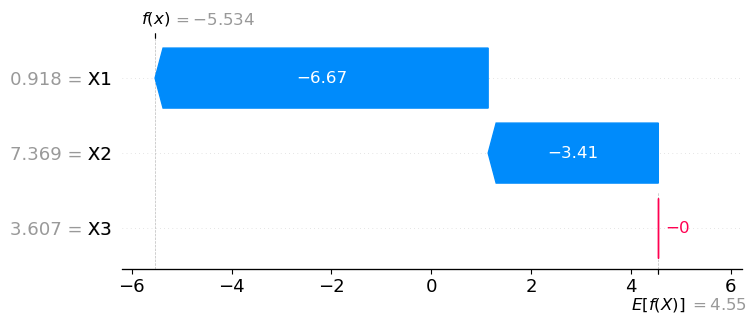

In [281]:
shap.plots.waterfall(shap_values[0])

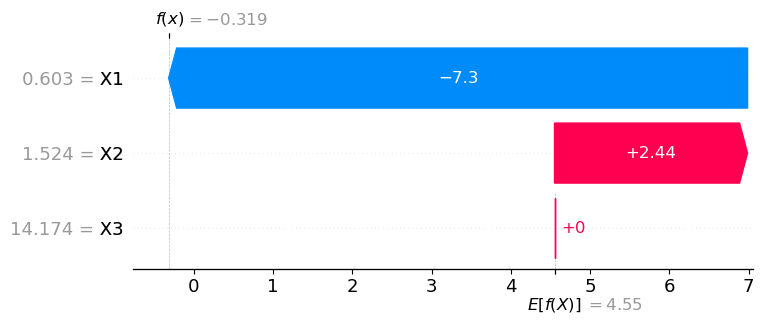

In [289]:
shap.plots.waterfall(shap_values[1])

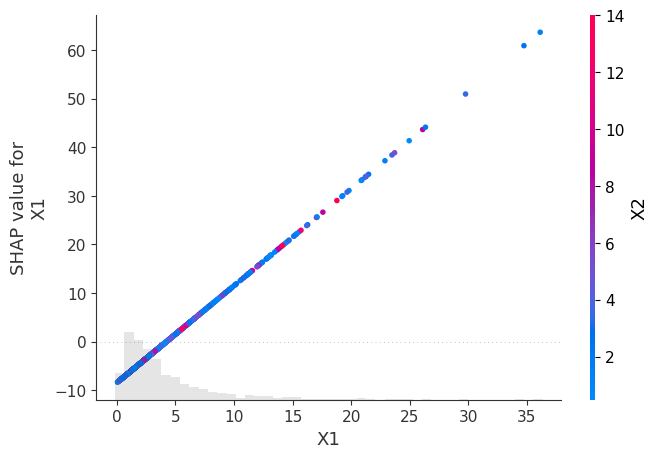

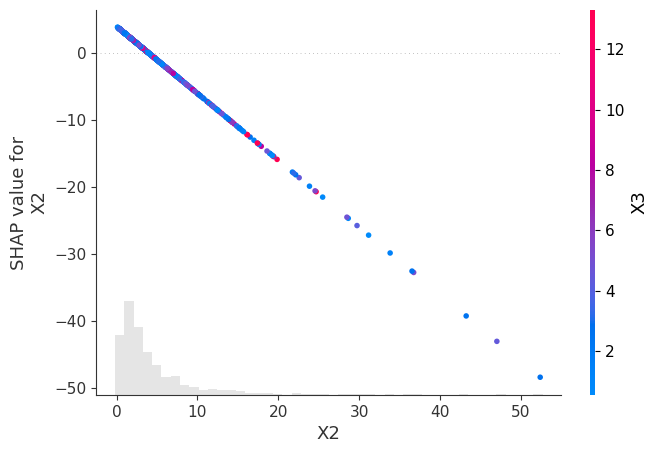

In [287]:
shap.plots.scatter(shap_values[:,"X1"], color=shap_values)
shap.plots.scatter(shap_values[:,"X2"], color=shap_values)

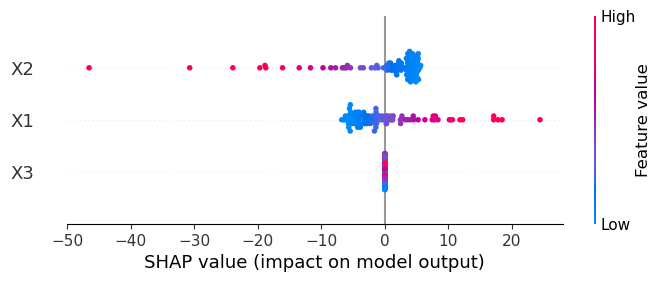

In [261]:
shap.plots.beeswarm(shap_values)

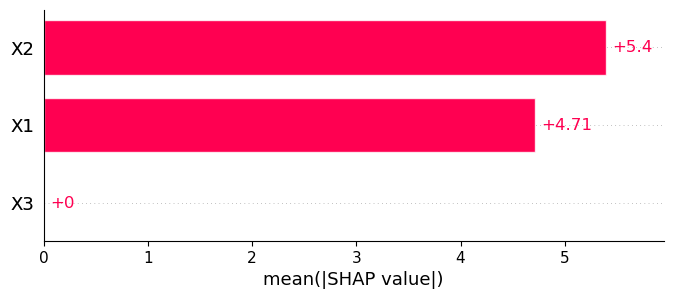

In [262]:
shap.plots.bar(shap_values)

In [97]:
shap.initjs()
shap.plots.force(shap_values)